In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

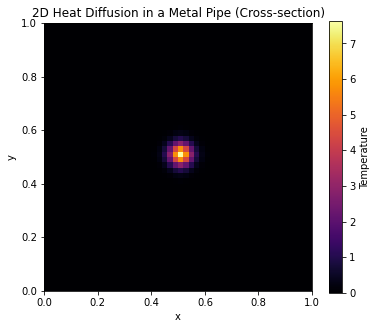

In [8]:
# Simulation parameters
Lx, Ly = 1.0, 1.0  # Length of the pipe in x and y directions
Nx, Ny = 50, 50    # Number of grid points
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # Grid spacing
alpha = 0.01       # Thermal diffusivity of the material
dt = 0.0001        # Time step
time_steps = 500   # Number of time steps

# Stability condition for the explicit method
if dt > (dx**2 * dy**2) / (2 * alpha * (dx**2 + dy**2)):
    raise ValueError("Time step is too large for stability.")

# Initialize temperature grid
T = np.zeros((Nx, Ny))
T_new = np.copy(T)

# Initial conditions: heat source in the center
T[Nx//2, Ny//2] = 100.0

# Boundary conditions (constant temperature boundaries)
def apply_boundary_conditions(T):
    T[0, :] = 0.0    # Left boundary
    T[-1, :] = 0.0   # Right boundary
    T[:, 0] = 0.0    # Bottom boundary
    T[:, -1] = 0.0   # Top boundary

# Main simulation loop
for step in range(time_steps):
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            T_new[i, j] = T[i, j] + alpha * dt * (
                (T[i+1, j] - 2 * T[i, j] + T[i-1, j]) / dx**2 +
                (T[i, j+1] - 2 * T[i, j] + T[i, j-1]) / dy**2
            )
    # Update temperature grid and apply boundary conditions
    T = np.copy(T_new)
    apply_boundary_conditions(T)

# Plot the final temperature distribution
plt.figure(figsize=(6, 5))
plt.imshow(T, extent=[0, Lx, 0, Ly], origin='lower', cmap=cm.inferno)
plt.colorbar(label="Temperature")
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Heat Diffusion in a Metal Pipe (Cross-section)")
plt.show()